In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from numpy.random import randn
from sklearn.neighbors import NearestNeighbors
# Backend support if Qt then comment %matplotlib widget
%gui qt
# Vispy modules
from vispy import app, scene
from vispy.scene import visuals

In [2]:
palette = dict({ 1:"#010cb1",  2:"#2a87dd",
                 3:"#c35950",  4:"#e8a600",
                 5:"#eded44",  6:"#9e0b4e",
                 7:"#69409e",  8:"#36c2f3",
                 9:"#5ba56e", 10:"#2c806f",
                11:"#a230cb", 12:"#ff3399",
                13:"#ffea28", 14:"#898c90",
                15:"#a3153f", 16:"#9776cd",
                17:"#341c68", 18:"#6c0d49",
                19:"#3c69b1", 20:"#95d5fa"
               })

# Definition of functions

In [3]:
def potential(r, attraction=1, repulsion=1, beta=2):
    return repulsion*np.exp(-r) - attraction*np.exp(-r/beta)

def dual(x):
    return x[np.newaxis].T

def unit(x, y, z):
    l = np.sqrt(x**2 + y**2 + z**2)
    x /= l
    y /= l
    z /= l
    return np.array([x, y, z]).T, l

# Generate randomly distributed cells

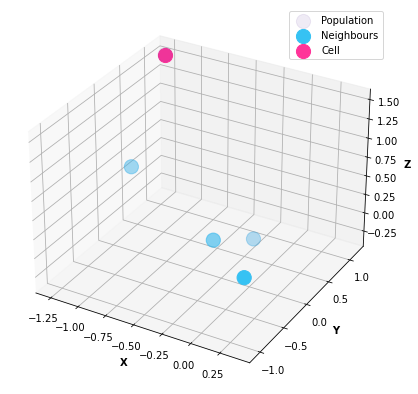

In [6]:
# Number of cells
N = 5
# Maximum distance between cells
l = 1
# Create a population of cells randomly distributed
cells = l*randn(N, 3)
# Compute KD-Neighbours
j = 3 # Target cell
neighbours = NearestNeighbors(algorithm='kd_tree').fit(cells)
_, indices = neighbours.kneighbors([cells[j]])
indices = indices[indices!=j]
# VISPY Plots ------------------------------------------------
ball = 200
# Define canvas and enable interactive PoV
canvas = scene.SceneCanvas(keys='interactive', show=True)
poview = canvas.central_widget.add_view()
# Call scatter plot
scatter = visuals.Markers()
scatter.set_data(cells, edge_width=0, face_color=palette[7], size=ball)
# Pull scatter plot
poview.add(scatter)
# Type of interactive PoV
poview.camera = 'turntable'
# Axes of reference - optional
axis = visuals.XYZAxis(parent=poview.scene)
# ------------------------------------------------
# Call to main for running vispy app
if __name__ == '__main__':
    import sys
    if sys.flags.interactive != 1:
        app.run()

# Matplotlib -------------------------------------
plt.close()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection="3d")
# Plot population of cells
ax.scatter(cells[:,0], cells[:,1], cells[:,2], 
           marker="o", 
           s=ball, 
           color=palette[7], 
           alpha=0.1,
           label="Population")
# Plot neares neighbours of target cell
ax.scatter(cells[indices.flatten()][:,0], 
           cells[indices.flatten()][:,1], 
           cells[indices.flatten()][:,2], 
           marker="o", 
           s=ball, 
           color=palette[8],
           label="Neighbours")
# Plot target cell
ax.scatter(cells[j,0], cells[j,1], cells[j,2], 
           marker="o", 
           s=ball, 
           color=palette[12],
           label="Cell")
ax.set_xlabel("X", weight="bold")
ax.set_ylabel("Y", weight="bold")
ax.set_zlabel("Z", weight="bold")
ax.legend()

# Compute cell-cell interactions (potential energy)

## Generate (random) polarisation vectors

In [7]:
# Apicobasal polarities
P = l*randn(N, 3)
P, _ = unit(P[:,0], P[:,1], P[:,2])

# Planar cell polarities
Q = l*randn(N, 3)
Q, _ = unit(Q[:,0], Q[:,1], Q[:,2])

## Compute potential

Calculate the weights of the attraction coefficients according to the formulae:

\begin{equation}
\begin{split}
S_1 &= (p^i \wedge r^{ij}) \cdot (p^j \wedge r^{ij}) = p^{i}_{\mu} p^{j}_{\mu} r^{ij}_{\mu}r^{ij}_{\mu} - p^{i}_{\mu}r^{ij}_{\mu} p^{j}_{\nu}r^{ij}_{\nu} \\
S_2 &= (p^i \wedge q^{i}) \cdot (p^j \wedge q^{j}) = p^{i}_{\mu} p^{j}_{\mu} q^{i}_{\nu}q^{j}_{\nu} - p^{i}_{\mu}q^{j}_{\mu} p^{j}_{\nu}q^{i}_{\nu} \\
S_3 &= (q^i \wedge r^{ij}) \cdot (q^j \wedge r^{ij}) = q^{i}_{\mu} q^{j}_{\mu} r^{ij}_{\mu}r^{ij}_{\mu} - q^{i}_{\mu}r^{ij}_{\mu} q^{j}_{\nu}r^{ij}_{\nu} \\
\end{split}
\end{equation}

The strength of attraction is $S$, where
\begin{equation}
S = \sigma_1 S_1 + \sigma_2 S_2 + \sigma_3 S_3, \qquad \sigma_1 + \sigma_2 + \sigma_3 = 1.
\end{equation}

In [8]:
def evolution(cells, P, Q, beta=5/2, sigma=[1/2, 1/4, 1/4]):
    U = np.zeros((N, N))
    dr = dp = dq = np.zeros((N, 3))
    for i in range(N):
        # Obtain k-nns for the ith cell
        _, k = neighbours.kneighbors([cells[i]])
        k = k[k!=i]
        dr_ij = dp_ij = dq_ij = 0
        for j in k:
            # Components of the radiovectors from the ith cell to its neighbours
            x = cells[i,0] - cells[j,0]
            y = cells[i,1] - cells[j,1]
            z = cells[i,2] - cells[j,2]
            # Compute the unitaries (d=|r_ij|)
            r, d = unit(x, y, z)
            # Apicobasal and planar-cell polarity vectors (ith cell and its neighbours)
            Pi, Pj = P[i], P[j]
            Qi, Qj = Q[i], Q[j]
            # Inner product between Pi and Pj
            PiPj = (Pi*Pj).sum(axis=0)
            # Inner product between Qi and Qj
            QiQj = (Pi*Pj).sum(axis=0)
            # Inner product between Pi and Qj
            PiQj = (Pi*Qj).sum(axis=0)
            # Inner product between Qi and Pj
            QiPj = (Qi*Pj).sum(axis=0)
            # Component S1
            S1 = PiPj * (r**2).sum(axis=0) - (Pi*r).sum(axis=0) * (Pj*r).sum(axis=0)
            # Component S2
            S2 = PiPj * QiQj - PiQj * QiPj
            # Component S3
            S3 = QiQj * (r**2).sum(axis=0) - (Qi*r).sum(axis=0) * (Qj*r).sum(axis=0)
            # Constitutive relation
            S = sigma[0]*S1 + sigma[1]*S2 + sigma[2]*S3
            # Potential U
            U[i,j] = np.exp(-d) - S*np.exp(-d/beta)
            # ----------------------------------------------
            # Differentials - cell positions: dV/dr
            # ----------------------------------------------
            # Factor term (r, Pi) Pj
            rPi_Pj = (r*Pi).sum(axis=0) * Pj
            # Factor term (r, Pj) Pi
            rPj_Pi = (r*Pj).sum(axis=0) * Pi
            # Factor term (r, Qi) Qj
            rQi_Qj = (r*Qi).sum(axis=0) * Qj
            # Factor term (r, Qj) Qi
            rQj_Qi = (r*Qj).sum(axis=0) * Qi
            # Gamma (residual)
            A = (sigma[0]*(r*Pi).sum(axis=0) * (r*Pj).sum(axis=0) + 
                 sigma[2]*(r*Qi).sum(axis=0) * (r*Qj).sum(axis=0))
            gamma = np.exp(-d*(beta-1)/beta) - S/beta + 2/r*A
            # Differential of position vector
            dr_ij += np.exp(-d/beta)*(gamma*r -
                                      sigma[0]/d*(rPi_Pj + rPj_Pi) - 
                                      sigma[2]/d*(rQi_Qj + rQj_Qi))
            # ----------------------------------------------
            # Differentials - ABP vectors: dV/dp
            # ----------------------------------------------
            dp_ij += np.exp(-d/beta)*(sigma[0]*(S1*Pi - Pj + (r*Pj).sum(axis=0)*r) +
                                      sigma[1]*(S2*Pi - QiQj*Pj + QiPj*r))
            # ----------------------------------------------
            # Differentials - PCP vectors: dV/dq
            # ----------------------------------------------
            dq_ij += np.exp(-d/beta)*(sigma[1]*(S2*Qi - PiPj*Qj + PiQj*Pj) +
                                      sigma[2]*(S3*Qi - Qj + (r*Qj).sum(axis=0)*r))
        # ----------------------------------------------
        dr[i,:] = dr_ij
        dp[i,:] = dp_ij
        dq[i,:] = dq_ij
    #U = (U.transpose() + U)/2.
    return dr, dp, dq

In [9]:
def intEvolution(r, p, q, t, w=1e-3):
    dt = t[1] - t[0]
    # Save states 
    R = [] 
    P = []
    Q = []
    R.append(r), P.append(r), Q.append(q)
    # Integration
    for i in t:    
        # Evolve states
        r, p, q = evolution(r, p, q)
        r += dt*r + np.random.normal(0, w, size=3)
        p += dt*p + np.random.normal(0, w, size=3) 
        q += dt*q + np.random.normal(0, w, size=3)
        p, _ = unit(p[:,0], p[:,1], p[:,2])
        q, _ = unit(q[:,0], p[:,1], p[:,2])
        # Update states
        R.append(r), P.append(r), Q.append(q)
    return R, P, Q

steps = 5

t = np.linspace(0, 1, steps)

Rt, Pt, Qt = intEvolution(cells, P, Q, t)

In [28]:
# VISPY -------------------------------------------------
ball = 200
# Define canvas and enable interactive PoV
canvas = scene.SceneCanvas(keys='interactive', show=True)
poview = canvas.central_widget.add_view()
scatter = visuals.Markers()

i = 0
def update(ev):
    
    global i, scatter

    if i > 0 and i < 6:
        # Call scatter plot
        scatter.set_data(Rt[i], edge_width=0, face_color="#258ACA", size=ball)
    
        # Pull scatter plot
        poview.add(scatter)
    
        # Type of interactive PoV
        poview.camera = 'turntable'
        canvas.update()
        i += 1
        
    else:
        i += -1

# Setup timer
timer = app.Timer()
timer.connect(update)
timer.start(1)

if __name__ == '__main__':
    app.run()

ERROR: Invoking <function update at 0x2a7f4ed30> repeat 512


## Compute Potential Energy (optional)

In [ ]:
"""
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# Plots
plt.close()
plt.figure(1, figsize=(8,8), constrained_layout=False)
ax = plt.gca()
im = ax.matshow(U, cmap=plt.get_cmap("terrain"))
ax.set_xlabel("Cell", size=14, weight="bold")
ax.set_ylabel("Cell", size=14, weight="bold")
ax.set_xticks(np.arange(N), labels=np.arange(1,N+1))
ax.set_yticks(np.arange(N), labels=np.arange(1,N+1))
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.1), label="Energy")
"""